<a href="https://colab.research.google.com/github/1kaiser/Media-Segment-Depth-MLP/blob/main/MLP_Image_Train_Inference_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### **Downloading the dataset**

download [flower dataset](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition?resource=download) from kaggle.

In [ ]:
from google.colab import output
!wget https://github.com/1kaiser/Media-Segment-Depth-MLP/releases/download/v0.2/archive.zip -O archive.zip
!unzip /content/archive.zip #unzipping the flower images from archive..
output.clear()
##########################<< copying all varities into a single folder block >>################
!mkdir -p /content/flowers/all
!cp /content/flowers/daisy/* /content/flowers/all
!cp /content/flowers/dandelion/* /content/flowers/all
!cp /content/flowers/rose/* /content/flowers/all
!cp /content/flowers/sunflower/* /content/flowers/all
!cp /content/flowers/tulip/* /content/flowers/all
##########################<< end of block >>################
print("creating single image folder complete >>>")


## **RUN** 

**Model and training code**
Our model is a coordinate-based multilayer perceptron. In this example, for each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$ or any $(gray)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

**POSITIONAL ENCODING BLOCK** 

In [ ]:
#✅
import jax
import jax.numpy as jnp

positional_encoding_dims = 6  # Number of positional encodings applied

def positional_encoding(args):
    image_height_x_image_width, cha = args.shape
    inputs_freq = jax.vmap(lambda x: args * 2.0 ** x)(jnp.arange(positional_encoding_dims))
    x = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    x = x.swapaxes(0, 2)
    x = x.reshape([image_height_x_image_width, -1])
    x = jnp.concatenate([args, x], axis=-1)
    return x



**MLP MODEL DEFINATION**
Basically, passing input points through a simple Fourier Feature Mapping enables an MLP to learn high-frequency functions (such as an RGB image) in low-dimensional problem domains (such as a 2D coordinate of pixels).

In [ ]:
#✅
!python -m pip install -qq -U flax orbax
# Orbax needs to enable asyncio in a Colab environment.
!python -m pip install -qq nest_asyncio

import jax
import jax.numpy as jnp

import flax
import optax
from typing import Any

from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

apply_positional_encoding = True # Apply posittional encoding to the input or not
ndl = 8 # num_dense_layers Number of dense layers in MLP
dlw = 256 # dense_layer_width Dimentionality of dense layers' output space 

##########################################<< MLP MODEL >>#########################################
class MLPModel(nn.Module):
    dtype: Any = jnp.float32
    precision: Any = lax.Precision.DEFAULT
    apply_positional_encoding: bool = apply_positional_encoding
    @nn.compact
    def __call__(self, input_points):
        x = positional_encoding(input_points) if self.apply_positional_encoding else input_points
        for i in range(ndl):
            x = nn.Dense(dlw,dtype=self.dtype,precision=self.precision)(x)
            x = nn.relu(x)
            x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x
  
        x = nn.Dense(1, dtype=self.dtype, precision=self.precision)(x)
        return x
##########################################<< MLP MODEL >>#########################################

**initialize the module**

In [ ]:
#✅
!python -m pip install -q -U flax
import optax
from flax.training import train_state
import jax.numpy as jnp
import jax


def Create_train_state(r_key, model, shape, learning_rate ) -> train_state.TrainState:
    print(shape)
    variables = model.init(r_key, jnp.ones(shape)) 
    optimizer = optax.adam(learning_rate) 
    return train_state.TrainState.create(
        apply_fn = model.apply,
        tx=optimizer,
        params=variables['params']
    )

learning_rate = 1e-4
batch_size_no = 64

model = MLPModel() # Instantiate the Model

**defining loss function**

In [ ]:
#serial
def image_difference_loss(logits, labels):
    loss = .5 * jnp.mean((logits - labels) ** 2) 
    return loss
def compute_metrics(*, logits, labels):
  loss = image_difference_loss(logits, labels)
  metrics = {
      'loss': loss,     #LOSS
      'logits': logits, #PREDICTED IMAGE
      'labels': labels  #ACTUAL IMAGE
  }
  return metrics

**train step defination**

In [ ]:
#cpu serial
import jax

def train_step(state: train_state.TrainState, batch: jnp.asarray, rng):
    image, label = batch  
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, image);
        loss =  image_difference_loss(logits, label);
        return loss, logits

    gradient_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = gradient_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    logs = compute_metrics(logits=logits, labels=label)
    return new_state, logs

import jax
@jax.jit
def eval_step(state, image):
    logits = state.apply_fn({'params': state.params}, image)
    return compute_metrics(logits=logits, labels=image)


**image conversion fiunctions**

In [ ]:
from PIL import Image
import jax.numpy as jnp
def imageGRAY(argv):
    im = Image.open(argv).convert('L')
    tvt, tvu = jnp.asarray(im.resize(newsize)),jnp.asarray(im.resize(newsize)).reshape(-1,1)
    return tvt, tvu
def imageRGB(argv):
    im = Image.open(argv)
    tvt, tvu = jnp.asarray(im.resize(newsize)),jnp.asarray(im.resize(newsize)).reshape(-1,3)
    return tvt, tvu

**image dataset, image size and batch size Setup**

In [ ]:
########################################## to load the data in batches as mentioned single batch of images with already provided sizes 
import jax
from jax import random

newsize = (140,140) #(260, 260) # /.... 233 * 454
batch_size = 1

import os
image_dir = r'/content/flowers/tulip/'
#############################################################################
bandend = ["c",".jpg", "b02"]
expression_b2 = bandend[1]
total_images =  [f for f in os.listdir(image_dir) if f.__contains__(expression_b2)]
total_images.sort()
total_images_path = [os.path.join(image_dir, i) for i in total_images if i != 'outputs']
no_of_batches = int(len(total_images_path)/batch_size)

######################################## making 8 array of input for each device >>>
def batchedimages(image_locations):
  RGB8 = jnp.asarray((imageRGB(total_images_path[image_locations[0]])[1]))
  GRAY8 = jnp.asarray((imageGRAY(total_images_path[image_locations[0]])[1]))
  batch_ccc = RGB8, GRAY8 
  return batch_ccc

def data_stream():
  key = random.PRNGKey(0)
  perm = random.permutation(key, len(total_images_path))
  for i in range(no_of_batches):
    batch_idx = perm[i * batch_size : (i + 1) * batch_size]; #print(batch_idx)
    yield batchedimages(batch_idx)

batches = data_stream()  

In [ ]:
#@title # **👠HIGH HEELS RUN >>>>>>>>>>>** { vertical-output: true }
newsize = (140,140) #(260, 260) # /.... 233 * 454

import jax
from jax import random
from tqdm import tqdm
import re
from google.colab import output
import orbax.checkpoint as orbax
from flax.training import checkpoints

import optax
import nest_asyncio
nest_asyncio.apply()

rng = jax.random.PRNGKey(0)
CKPT_DIR = 'ckpts'

######################<<<< initiating train state
count = 0
if count == 0 :
  HxW, Channels = next(batches)[0].shape
  state = Create_train_state( rng, model, (HxW, Channels), learning_rate ) 
  count = 1
#✅✅🔻 state = flax.jax_utils.replicate(state)  # FLAX will replicate the state to every device so that updating can be made easy

###################### 
checkpoint_available = 0
pattern = re.compile("checkpoint_\d+")   # to search for "checkpoint_*munerical value*" numerical value of any length is denoted by regular expression "\d+"
dir = "/content/ckpts/"
isFile = os.path.isdir(dir)
if isFile:
  for filepath in os.listdir(dir):
      if pattern.match(filepath):
          checkpoint_available = 1

total_epochs = 50
for epochs in tqdm(range(total_epochs)):  
  batches = data_stream() 

  if checkpoint_available:
    state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
    checkpoint_available = 0 # << Flag updated >>> to stop loading the same checkpoint in the next iteration then remove the checkpoint directory
    !rm -r {dir}

  for bbb in tqdm(range(no_of_batches-5)):
    state, metrics = train_step(state, next(batches), rng)
    output.clear()
    print("loss: ",metrics['loss']," <<< ") # naming of the checkpoint is "checkpoint_*"  where "*" => value of the steps variable, i.e. 'epochs'
  orbax_checkpointer = orbax.Checkpointer(orbax.PyTreeCheckpointHandler())
  checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step=epochs, prefix='checkpoint_', keep=1, overwrite=False, orbax_checkpointer=orbax_checkpointer)
  # restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state) # using to get the checkpoint loaded , it can be latest one , or if already available as checkpoint in the "CKPT_DIR" directory then take the file from directory then save in >> restored_checkpoints
  ##################################################



**inference engine**

In [ ]:

# newsize = (140,140) #(260, 260) # /.... 233 * 454
from google.colab.patches import cv2_imshow
import numpy as np 
from google.colab import output
from flax.training import checkpoints

!wget https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg -O a.jpg
image_in = '/content/a.jpg'

from PIL import Image
import jax.numpy as jnp
def imageRGB(argv):
    im = Image.open(argv)
    tvt, tvu = jnp.asarray(im.resize(newsize)),jnp.asarray(im.resize(newsize)).reshape(-1,3)
    return tvt, tvu
image = jnp.asarray((imageRGB(image_in)[1]))
#restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
#state = restored_state
#initialize
HxW, Channels = image.shape
state = Create_train_state( model, rng, (HxW, Channels), learning_rate ) 

state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
prediction = eval_step(state, image)
prediction['loss']


predicted_image = np.array(prediction['logits'],  dtype=np.uint8).reshape(newsize) 
cv2_imshow(predicted_image)


In [ ]:
# import cv2
# from google.colab.patches import cv2_imshow
# import numpy as np 
# def show_image(argu):
#   L1 = argu[0]
#   predicted_image = np.array(argu[0],  dtype=np.uint8).reshape(newsize) # This would be your image array
#   a = predicted_image
#   for i in range(0,argu.shape[0]):
#     predicted_image = np.array(argu[i],  dtype=np.uint8).reshape(newsize) 
#     a = cv2.hconcat([a, predicted_image])
#   cv2_imshow(a)

# show_image(metrics['logits'])

In [ ]:
# from jax.tree_util import tree_structure
# print(tree_structure(state))

##**test dataset segmentation Creation download section**

In [ ]:
##################################<<< MEDIAPIPE LIBRARY INSTALLATON >>>#############################
!python -m pip install mediapipe
##################################<<< FRAME EXTRACTION >>>#############################
video_location = '/content/drive/MyDrive/OUT/data/machine_learning_test_dataset/test.mp4'
import os

 
# Read images with OpenCV.
#images= None
image_dir = '/content/MEDIAPIPEinput/'
os.makedirs(image_dir, exist_ok=True)
image_dir_out = '/content/annotated_images'
os.makedirs(image_dir_out, exist_ok=True)
frame_rate = 25
!ffmpeg -y -hwaccel cuvid \
  -i {video_location} \
  -r {frame_rate} {image_dir}out_%09d.png

imgs_list = os.listdir(image_dir)
imgs_list.sort()
imgs_path = [os.path.join(image_dir, i) for i in imgs_list if i != 'outputs']
################################<<< SEGMENTATION USING MEDIAPIPE >>>###################################
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import mediapipe as mp
# mp_holistic = mp.solutions.holistic
mp_pose = mp.solutions.pose
!rm -r {image_dir}.ipynb_checkpoints

# Run MediaPipe Pose with `enable_segmentation=True` to get pose segmentation.
with mp_pose.Pose(static_image_mode=True, 
                          min_detection_confidence=0.2,
                          model_complexity=2, 
                          enable_segmentation=True,) as pose:
  temp_segmentation_mask =[]                        
  for name, image in enumerate(imgs_path):
    !rm -r {image_dir}.ipynb_checkpoints
    # Convert the BGR image to RGB and process it with MediaPipe Pose.
    image = cv2.imread(image)
    results = pose.process(image)

    # Draw pose segmentation.
    print(f'Pose segmentation of {name}:')
    annotated_image_pose = image.copy()
    red_img = np.zeros_like(annotated_image_pose, dtype=np.uint8)
    red_img[:, :] = (255,255,255)
    ###check if segmentation_mask exists or not ## if exists then ok Else use previous mask temporarily
    if results.segmentation_mask is None:
      print("true")
      results.segmentation_mask = temp_segmentation_mask[-1]
      temp_segmentation_mask.append(results.segmentation_mask)
    else:
      temp_segmentation_mask.append(results.segmentation_mask)
    ###End check if segmentation_mask exists or not ## if exists then ok Else use previous mask temporarily
    segm_2class = 0.0 + 1.0 * results.segmentation_mask
    segm_2class = np.repeat(segm_2class[..., np.newaxis], 3, axis=2)
    annotated_image_pose = annotated_image_pose * segm_2class + red_img * (1 - segm_2class)
    #resize_and_show(annotated_image)
    cv2.imwrite('%s/%s' %(image_dir_out, imgs_list[name]), annotated_image_pose)
    !rm -r {image_dir_out}.ipynb_checkpoints


## **RUN 2** 

**Model and training code**
Our model is a coordinate-based multilayer perceptron. In this example, for each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$ or any $(gray)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

**POSITIONAL ENCODING BLOCK** 

In [ ]:
#✅
import jax
import jax.numpy as jnp

positional_encoding_dims = 6  # Number of positional encodings applied

def positional_encoding(args):
    image_height_x_image_width, cha = args.shape
    inputs_freq = jax.vmap(lambda x: args * 2.0 ** x)(jnp.arange(positional_encoding_dims))
    x = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    x = x.swapaxes(0, 2)
    x = x.reshape([image_height_x_image_width, -1])
    x = jnp.concatenate([args, x], axis=-1)
    return x



**MLP MODEL DEFINATION**
Basically, passing input points through a simple Fourier Feature Mapping enables an MLP to learn high-frequency functions (such as an RGB image) in low-dimensional problem domains (such as a 2D coordinate of pixels).

In [ ]:
#✅
!python -m pip install -qq -U flax orbax
# Orbax needs to enable asyncio in a Colab environment.
!python -m pip install -qq nest_asyncio


import jax
import jax.numpy as jnp

import flax
import optax
from typing import Any

from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

apply_positional_encoding = True # Apply posittional encoding to the input or not
ndl = 8 # num_dense_layers Number of dense layers in MLP
dlw = 256 # dense_layer_width Dimentionality of dense layers' output space 

##########################################<< MLP MODEL >>#########################################
class MLPModel(nn.Module):
    dtype: Any = jnp.float32
    precision: Any = lax.Precision.DEFAULT
    apply_positional_encoding: bool = apply_positional_encoding
    @nn.compact
    def __call__(self, input_points):
        x = positional_encoding(input_points) if self.apply_positional_encoding else input_points
        for i in range(ndl):
            x = nn.Dense(dlw,dtype=self.dtype,precision=self.precision)(x)
            x = nn.relu(x)
            x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x
  
        x = nn.Dense(1, dtype=self.dtype, precision=self.precision)(x)
        return x
##########################################<< MLP MODEL >>#########################################

**initialize the module**

In [ ]:
#✅
!python -m pip install -q -U flax
import optax
from flax.training import train_state
import jax.numpy as jnp
import jax


def Create_train_state(r_key, model, shape, learning_rate ) -> train_state.TrainState:
    print(shape)
    variables = model.init(r_key, jnp.ones(shape)) 
    optimizer = optax.adam(learning_rate) 
    return train_state.TrainState.create(
        apply_fn = model.apply,
        tx=optimizer,
        params=variables['params']
    )

learning_rate = 1e-4
batch_size_no = 64

model = MLPModel() # Instantiate the Model

**defining loss function**

In [ ]:
#serial
def image_difference_loss(logits, labels):
    loss = .5 * jnp.mean((logits - labels) ** 2) 
    return loss
def compute_metrics(*, logits, labels):
  loss = image_difference_loss(logits, labels)
  metrics = {
      'loss': loss,     #LOSS
      'logits': logits, #PREDICTED IMAGE
      'labels': labels  #ACTUAL IMAGE
  }
  return metrics

**train step defination**

In [ ]:
#cpu serial
import jax

def train_step(state: train_state.TrainState, batch: jnp.asarray, rng):
    image, label = batch  
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, image);
        loss =  image_difference_loss(logits, label);
        return loss, logits

    gradient_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = gradient_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    logs = compute_metrics(logits=logits, labels=label)
    return new_state, logs

import jax
@jax.jit
def eval_step(state, image):
    logits = state.apply_fn({'params': state.params}, image)
    return compute_metrics(logits=logits, labels=image)


**image conversion fiunctions**

In [ ]:
from PIL import Image
import jax.numpy as jnp
def imageGRAY(argv):
    im = Image.open(argv).convert('L')
    tvt, tvu = jnp.asarray(im.resize(newsize)),jnp.asarray(im.resize(newsize)).reshape(-1,1)
    return tvt, tvu
def imageRGB(argv):
    im = Image.open(argv)
    tvt, tvu = jnp.asarray(im.resize(newsize)),jnp.asarray(im.resize(newsize)).reshape(-1,3)
    return tvt, tvu

**image dataset, image size and batch size Setup**

In [ ]:
########################################## to load the data in batches as mentioned single batch of images with already provided sizes 
import jax
from jax import random

newsize = (140,140) #(260, 260) # /.... 233 * 454
batch_size = 1

import os
image_dir = r'/content/MEDIAPIPEinput'
annotated_image_dir = r'/content/annotated_images'

#############################################################################
bandend = ["c",".png", "b02"]
expression_b2 = bandend[1]

total_images =  [f for f in os.listdir(image_dir) if f.__contains__(expression_b2)]
total_images.sort()
total_images_path = [os.path.join(image_dir, i) for i in total_images if i != 'outputs']

annotated_total_images =  [f for f in os.listdir(annotated_image_dir) if f.__contains__(expression_b2)]
annotated_total_images.sort()
annotated_total_images_path = [os.path.join(annotated_image_dir, i) for i in annotated_total_images if i != 'outputs']

no_of_batches = int(len(total_images_path)/batch_size)

######################################## making 8 array of input for each device >>>
def batchedimages(image_locations):
  RGB8 = jnp.asarray((imageRGB(total_images_path[image_locations[0]])[1]))
  ANNOTATED8 = jnp.asarray((imageRGB(annotated_total_images_path[image_locations[0]])[1]))
  batch_ccc = RGB8, ANNOTATED8 
  return batch_ccc

def data_stream():
  key = random.PRNGKey(0)
  perm = random.permutation(key, len(total_images_path))
  for i in range(no_of_batches):
    batch_idx = perm[i * batch_size : (i + 1) * batch_size]; #print(batch_idx)
    yield batchedimages(batch_idx)

batches = data_stream()  

In [ ]:
next(batches)[0].shape

In [ ]:
#@title # **👠HIGH HEELS RUN >>>>>>>>>>>** { vertical-output: true }
newsize = (140,140) #(260, 260) # /.... 233 * 454

import jax
from jax import random
from tqdm import tqdm
import re
from google.colab import output
import orbax.checkpoint as orbax
from flax.training import checkpoints

import optax
import nest_asyncio
nest_asyncio.apply()

rng = jax.random.PRNGKey(0)
CKPT_DIR = 'ckpts'

######################<<<< initiating train state
count = 0
if count == 0 :
  HxW, Channels = next(batches)[0].shape
  state = Create_train_state( rng, model, (HxW, Channels), learning_rate ) 
  count = 1
#✅✅🔻 state = flax.jax_utils.replicate(state)  # FLAX will replicate the state to every device so that updating can be made easy

###################### 
checkpoint_available = 0
pattern = re.compile("checkpoint_\d+")   # to search for "checkpoint_*munerical value*" numerical value of any length is denoted by regular expression "\d+"
dir = "/content/ckpts/"
isFile = os.path.isdir(dir)
if isFile:
  for filepath in os.listdir(dir):
      if pattern.match(filepath):
          checkpoint_available = 1

total_epochs = 50
for epochs in tqdm(range(total_epochs)):  
  batches = data_stream() 

  if checkpoint_available:
    state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
    checkpoint_available = 0 # << Flag updated >>> to stop loading the same checkpoint in the next iteration then remove the checkpoint directory
    !rm -r {dir}

  for bbb in tqdm(range(no_of_batches-5)):
    state, metrics = train_step(state, next(batches), rng)
    output.clear()
    print("loss: ",metrics['loss']," <<< ") # naming of the checkpoint is "checkpoint_*"  where "*" => value of the steps variable, i.e. 'epochs'
  orbax_checkpointer = orbax.Checkpointer(orbax.PyTreeCheckpointHandler())
  checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step=epochs, prefix='checkpoint_', keep=1, overwrite=False, orbax_checkpointer=orbax_checkpointer)
  # restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state) # using to get the checkpoint loaded , it can be latest one , or if already available as checkpoint in the "CKPT_DIR" directory then take the file from directory then save in >> restored_checkpoints
  ##################################################



**inference engine**

In [ ]:

# newsize = (140,140) #(260, 260) # /.... 233 * 454
from google.colab.patches import cv2_imshow
import numpy as np 
from google.colab import output

!wget https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg -O a.jpg
image_in = '/content/a.jpg'

from PIL import Image
import jax.numpy as jnp
def imageRGB(argv):
    im = Image.open(argv)
    tvt, tvu = jnp.asarray(im.resize(newsize)),jnp.asarray(im.resize(newsize)).reshape(-1,3)
    return tvt, tvu
image = jnp.asarray((imageRGB(image_in)[1]))
#restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
#state = restored_state
prediction = eval_step(state, image)
prediction['loss']


predicted_image = np.array(prediction['logits'],  dtype=np.uint8).reshape(newsize) 
cv2_imshow(predicted_image)


In [ ]:
# import cv2
# from google.colab.patches import cv2_imshow
# import numpy as np 
# def show_image(argu):
#   L1 = argu[0]
#   predicted_image = np.array(argu[0],  dtype=np.uint8).reshape(newsize) # This would be your image array
#   a = predicted_image
#   for i in range(0,argu.shape[0]):
#     predicted_image = np.array(argu[i],  dtype=np.uint8).reshape(newsize) 
#     a = cv2.hconcat([a, predicted_image])
#   cv2_imshow(a)

# show_image(metrics['logits'])

In [ ]:
# from jax.tree_util import tree_structure
# print(tree_structure(state))

##**ensemble**

In [ ]:
#✅
!python -m pip install -q -U flax
from typing import Any
import jax
from jax import lax
import jax.numpy as jnp
import optax
import flax
import flax.linen as nn
from flax.training import train_state, common_utils
import functools

positional_encoding_dims = 6  # Number of positional encodings applied

def positional_encoding(args):
    image_height_x_image_width, cha = args.shape
    inputs_freq = jax.vmap(lambda x: args * 2.0 ** x)(jnp.arange(positional_encoding_dims))
    x = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    x = x.swapaxes(0, 2)
    x = x.reshape([image_height_x_image_width, -1])
    x = jnp.concatenate([args, x], axis=-1)
    return x

apply_positional_encoding = True # Apply posittional encoding to the input or not
ndl = 8 # num_dense_layers Number of dense layers in MLP
dlw = 256 # dense_layer_width Dimentionality of dense layers' output space 

##########################################<< MLP MODEL >>#########################################
class MLPModel(nn.Module):
    dtype: Any = jnp.float32
    precision: Any = lax.Precision.DEFAULT
    apply_positional_encoding: bool = apply_positional_encoding
    @nn.compact
    def __call__(self, input_points):
        x = positional_encoding(input_points) if self.apply_positional_encoding else input_points
        for i in range(ndl):
            x = nn.Dense(dlw,dtype=self.dtype,precision=self.precision)(x)
            x = nn.relu(x)
            x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x
  
        x = nn.Dense(1, dtype=self.dtype, precision=self.precision)(x)
        return x
##########################################<< MLP MODEL >>#########################################

@functools.partial(jax.pmap, static_broadcasted_argnums=(1, 2))
def Create_train_state(r_key, shape, learning_rate ):
    print(shape)
    model = MLPModel()
    variables = model.init(r_key, jnp.ones(shape)) 
    optimizer = optax.adam(learning_rate) 
    return train_state.TrainState.create(
        apply_fn = model.apply,
        tx=optimizer,
        params=variables['params']
    )

# learning_rate = 1e-4
# batch_size_no = 64

# model = MLPModel() # Instantiate the Model

In [ ]:
@functools.partial(jax.pmap, axis_name='ensemble')
def apply_model(state, batch: jnp.asarray):
  image, label = batch
  def loss_fn(params):
    logits = MLPModel().apply({'params': params}, image)
    loss =  image_difference_loss(logits, label);
    return loss, logits

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  return grads, loss

@jax.pmap
def update_model(state, grads):
  return state.apply_gradients(grads=grads)

In [ ]:
def train_epoch(state, train_ds, batch_size, rng):
  train_ds_size = len(train_ds['image'])
  steps_per_epoch = train_ds_size // batch_size

  perms = jax.random.permutation(rng, len(train_ds['image']))
  perms = perms[:steps_per_epoch * batch_size]
  perms = perms.reshape((steps_per_epoch, batch_size))

  epoch_loss = []

  for perm in perms:
    batch_images = jax_utils.replicate(train_ds['image'][perm, ...])
    batch_labels = jax_utils.replicate(train_ds['label'][perm, ...])
    grads, loss = apply_model(state, batch_images, batch_labels)
    state = update_model(state, grads)
    epoch_loss.append(jax_utils.unreplicate(loss))
  train_loss = np.mean(epoch_loss)
  return state, train_loss

In [ ]:
train_ds, test_ds = get_datasets()
test_ds = jax_utils.replicate(test_ds)
rng = jax.random.PRNGKey(0)

rng, init_rng = jax.random.split(rng)

HxW, Channels = next(batches)[0].shape
state = create_train_state(jax.random.split(init_rng, jax.device_count()),(HxW, Channels),learning_rate)

for epoch in range(1, num_epochs + 1):
  rng, input_rng = jax.random.split(rng)
  state, train_loss = train_epoch(state, train_ds, batch_size, input_rng)

  # _, test_loss = jax_utils.unreplicate(apply_model(state, test_ds['image'], test_ds['label']))

  logging.info('epoch:% 3d, train_loss: %.4f ' % (epoch, train_loss))

In [ ]:
# same as before, but using @pad_shard_unshard decorator

# manually padding
# => precise & allows for data parallelism

@jax.pmap
def get_preds(variables, inputs):
  print('retrigger compilation', inputs.shape)
  return model.apply(variables, inputs)

ds = tfds.load(dataset_name, split=tfds.split_for_jax_process('test'))
per_host_batch_size = per_device_batch_size * jax.local_device_count()
ds = ds.batch(per_host_batch_size, drop_remainder=False)

correct = total = 0
for batch in ds.as_numpy_iterator():
  preds = flax.jax_utils.pad_shard_unpad(get_preds)(
      vs, batch['image'], min_device_batch=per_device_batch_size)
  total += len(batch['image'])
  correct += (batch['label'] == preds.argmax(axis=-1)).sum()

correct = correct.item()
correct, total, correct / total

In [ ]:
def eval_step(metrics, variables, batch):
  print('retrigger compilation', {k: v.shape for k, v in batch.items()})
  preds = model.apply(variables, batch['image'])
  correct = (batch['mask'] & (batch['label'] == preds.argmax(axis=-1))).sum()
  total = batch['mask'].sum()
  return dict(
      correct=metrics['correct'] + jax.lax.psum(correct, axis_name='batch'),
      total=metrics['total'] + jax.lax.psum(total, axis_name='batch'),
  )

eval_step = jax.pmap(eval_step, axis_name='batch')
eval_step = flax.jax_utils.pad_shard_unpad(
    eval_step, static_argnums=(0, 1), static_return=True)

In [ ]:
%cd {total_files}
%cd ..
!zip -r folder.zip {total_files}

In [ ]:
!cp -r /content/folder.zip /content/drive/MyDrive/OUT/data/machine_learning_test_dataset

In [ ]:
!wget https://github.com/1kaiser/Media-Segment-Depth-MLP/releases/download/v0.2/s.zip

In [ ]:
!unzip /content/s.zip #unzipping the flower images from archive..

In [ ]:
total_files= '/content/s'
input_images = '/content/MEDIAPIPEinput'
out_images = '/content/annotated_images'
!mkdir -p {total_files}
!cp -r {input_images} {total_files}
!cp -r {out_images} {total_files}

In [ ]:
%cd {total_files}
!tfds new my_dataset

In [ ]:
total_files= '/content/s'
%cd {total_files}/my_dataset/
!tfds build

In [ ]:
!rm -r /content/t/my_dataset

In [ ]:
import os
def _generate_examples(self, path):
  """Yields examples."""
  # TODO(my_dataset): Yields (key, example) tuples from the dataset
  for f in path.glob('*.png'):
    yield 'key', {
        'MEDIAPIPEinput': f,
        'annotated_images': f,
    }
    
os.path = r'/content/s'
_generate_examples(path / 'MEDIAPIPEinput')

In [ ]:
import tensorflow_datasets as tfds
dl_manager = tfds.download.DownloadManager(download_dir='/content')
urls = 'https://github.com/1kaiser/Media-Segment-Depth-MLP/releases/download/v0.2/s.zip'
path = dl_manager.extract(dl_manager.download(urls))

In [ ]:
def _generate_examples( img_path):
  # Read the input data out of the source files
  # with img_path.open() as f:
    yield {
        'image': img_path / '*.png',
    }

def _split_generators():
    """Download the data and define splits."""
    dl_manager = tfds.download.DownloadManager(download_dir='/content')
    urls = 'https://github.com/1kaiser/Media-Segment-Depth-MLP/releases/download/v0.2/s.zip'
    path = dl_manager.extract(dl_manager.download(urls))    # dl_manager returns pathlib-like objects with `path.read_text()`,
    # `path.iterdir()`,...
    return {
        'in_image': _generate_examples(path / 'MEDIAPIPEinput'),
        'out_image': _generate_examples(path / 'annotated_images'),
    }
# _generate_examples(path/'MEDIAPIPEinput')
print(_split_generators()['in_image'])

In [ ]:
str(path)

In [ ]:
next(_generate_examples(path / 'MEDIAPIPEinput'))['image']

In [ ]:
class Builder(tfds.core.GeneratorBasedBuilder):
  """DatasetBuilder for my_dataset dataset."""

  VERSION = tfds.core.Version('1.0.0')
  RELEASE_NOTES = {
      '1.0.0': 'Initial release.',
  }

  def _info(self) -> tfds.core.DatasetInfo:
    """Dataset metadata (homepage, citation,...)."""
    return self.dataset_info_from_configs(
        features=tfds.features.FeaturesDict({
            'image': tfds.features.Image(shape=(256, 256, 3)),
            'label': tfds.features.Image(shape=(256, 256, 3)),
        }),
    )

  def _split_generators(self, dl_manager: tfds.download.DownloadManager):
    """Download the data and define splits."""
    urls = 'https://github.com/1kaiser/Media-Segment-Depth-MLP/releases/download/v0.2/s.zip'
    extracted_path = dl_manager.download_and_extract(urls)
    # dl_manager returns pathlib-like objects with `path.read_text()`,
    # `path.iterdir()`,...
    return {
        'train': self._generate_input_examples(path=extracted_path / 'MEDIAPIPEinput'),
        'test': self._generate_output_examples(path=extracted_path / 'annotated_images'),
    }

  def _generate_input_examples(self, path) -> Iterator[Tuple[Key, Example]]:
    """Generator of examples for each split."""
    for img_path in path.glob('*.png'):
      # Yields (key, example)
      yield img_path.name, {
          'image': img_path,
      }
  def _generate_output_examples(self, path) -> Iterator[Tuple[Key, Example]]:
    """Generator of examples for each split."""
    for img_path in path.glob('*.png'):
      # Yields (key, example)
      yield img_path.name, {
          'image': img_path,
      }

In [ ]:
# import the modules
import os
from os import listdir
 
# get the path or directory
folder_dir = str(path)+'/MEDIAPIPEinput/'
for images in os.listdir(folder_dir):
 
    # check if the image ends with png or jpg or jpeg
    if (images.endswith(".png") or images.endswith(".jpg") or images.endswith(".jpeg")):
        # display
        print(images)

In [ ]:
path

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
import tensorflow as tf

tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


In [ ]:
train_ds

In [ ]:
import pathlib
import tensorflow as tf

urls = 'https://github.com/1kaiser/Media-Segment-Depth-MLP/releases/download/v0.2/s.zip'
data_dir = tf.keras.utils.get_file(origin=urls,
                                   fname='s',
                                   cache_subdir='/content/biy',
                                   archive_format='auto',
                                   untar=False,
                                   extract=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
!rm -r /content/biy

In [ ]:
data_dir

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

In [ ]:


import flax.linen as nn
import jax.numpy as jnp
from jax.random import PRNGKey

x = jnp.empty((4, 28, 28, 1)) 

x.reshape((x.shape[0], -1)).shape

class MLP(nn.Module):                              # create a Flax Module dataclass

  @nn.compact
  def __call__(self, input_points):
    # x = x.reshape((x.shape[0], -1))
    # x = nn.Dense(128)(x)                           # create inline Flax Module submodules
    # x = nn.relu(x)
    # x = nn.Dense(1)(x)                 # shape inference
    # return x
    for i in range(8):
      x = nn.Dense(256)(x)
      x = nn.relu(x)
      x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x
      x = nn.Dense(1)(x)
      return x
model = MLP()                           # instantiate the MLP model

x = jnp.empty((4, 28, 28, 1))                      # generate random data
params = model.init(PRNGKey(42), x)["params"]      # initialize the weights
y = model.apply({"params":params}, x)  

In [ ]:
y.shape

In [ ]:
positional_encoding_dims = 6  # Number of positional encodings applied
import jax
import jax.numpy as jnp

def positional_encoding(args):
    image_height_x_image_width, cha = args.shape
    inputs_freq = jax.vmap(lambda x: args * 2.0 ** x)(jnp.arange(positional_encoding_dims))
    x = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    x = x.swapaxes(0, 2);print(x.shape)
    x = x.reshape([image_height_x_image_width, -1])
    x = jnp.concatenate([args, x], axis=-1)
    return x

x = jnp.empty((4, 28, 28, 1))
positional_encoding(x.reshape(x.shape[0],-1)).shape

In [ ]:
import glob, os
import tensorflow as tf
import numpy as np

PATH = '/content/biy/'
BATCH_SIZE = 12
IMAGE_SIZE = 140

def read_train_data():
    x_files = [f for f in glob.glob(PATH + "MEDIAPIPEinput/*.png", recursive=True)]
    y_files = [f for f in glob.glob(PATH + "annotated_images/*.png", recursive=True)]

    def read_image(x_filename, y_filename):
        x_image_string = tf.io.read_file(x_filename)
        y_image_string = tf.io.read_file(y_filename)

        x_image_decoded = tf.image.decode_jpeg(x_image_string, channels=3)
        y_image_decoded = tf.image.decode_jpeg(y_image_string, channels=3)

        x_image_resized = tf.image.resize(x_image_decoded, [IMAGE_SIZE, IMAGE_SIZE])
        y_image_resized = tf.image.resize(y_image_decoded, [IMAGE_SIZE, IMAGE_SIZE])

        x_image_norm = x_image_resized / 255
        y_image_norm = y_image_resized / 255

        return x_image_norm, y_image_norm

    dataset = tf.data.Dataset.from_tensor_slices((x_files, y_files))

    dataset = dataset.map(read_image).shuffle(1000).batch(BATCH_SIZE)

    return dataset

train_set = read_train_data()
for x, y in train_set.as_numpy_iterator():
  print(x.shape, y.shape)

In [ ]:
!python -m pip install -q -U flax
import functools
from flax.training.train_state import TrainState

def dice_coef(y_true, y_pred):
    y_true = jnp.ravel(y_true)
    y_pred = jnp.ravel(y_pred)
    intersection = jnp.sum(y_true * y_pred)
    return 2.0 * intersection / (jnp.sum(y_true) + jnp.sum(y_pred) + 1)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


class CustomTrainState(TrainState):
    def apply_fn_with_bn(self, *args, is_training, **nargs):
        output = self.apply_fn(*args, **nargs,rngs={'dropout': jax.random.PRNGKey(2)})
        return output

@functools.partial(jax.jit, static_argnums=(3,))
def train_step(x, y, train_state, is_training=True):
    def loss_fn(params, is_training):
        y_pred= train_state.apply_fn_with_bn({"params": params}, x, is_training=is_training)
        loss = dice_coef_loss(y, y_pred)

        return loss

    if is_training:
        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        (loss), grads = grad_fn(train_state.params, True)

        train_state = train_state.apply_gradients(grads=grads)
    else:
        loss = loss_fn(train_state.params, False)

    return loss, train_state

In [ ]:
import optax
unet = MLP(out_dims=10)

init_rngs = {'params': jax.random.PRNGKey(0), 'dropout': jax.random.PRNGKey(1)}

unet_variables = unet.init(init_rngs, jnp.ones([1, IMAGE_SIZE, IMAGE_SIZE, 3]))

optimizer = optax.adam(learning_rate=0.001)

train_state = CustomTrainState.create(apply_fn=unet.apply, params=unet_variables["params"], tx=optimizer)


for e in range(20):
        loss_avg = 0
        for x, y in train_set.as_numpy_iterator():
            loss, train_state = train_step(x, y, train_state, True)
            print(f"epoch: {e}, loss: {loss:0.2f}")

In [ ]:
x = jnp.empty((4, 28, 28, 3))
c = x[2]
c.shape
c = c.reshape(-1, c.shape[2])
p = positional_encoding(c)
print(p.shape)

In [ ]:
import jax
import jax.numpy as jnp
x = jnp.empty((4, 28, 28, 1))
print(x.shape)

def positional_encoding(args):
    print(args.shape)
    image_height_x_image_width, cha = args.shape
    inputs_freq = jax.vmap(lambda x: args * 2.0 ** x)(jnp.arange(6))
    x = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    x = x.swapaxes(0, 2);print(x.shape)
    x = x.reshape([image_height_x_image_width, -1])
    x = jnp.concatenate([args, x], axis=-1)
    return x

    
img_list = []
for i in range(x.shape[0]):
  print(i)
  print(x[i].shape)
  c = x[i]
  c.shape
  c = c.reshape(-1, c.shape[2])
  p = positional_encoding(c)
  img_list.append(p)
  print(p.shape)

In [ ]:
print(x.shape, jnp.array(img_list).shape)

##**starting here 🔻**

In [ ]:
#✅
!python -m pip install -q -U flax
import flax.linen as nn
from typing import Any
import jax
from jax import lax
import jax.numpy as jnp

positional_encoding_dims = 6  # Number of positional encodings applied

def positional_encoding(args):
    image_height_x_image_width, cha = args.shape
    inputs_freq = jax.vmap(lambda x: args * 2.0 ** x)(jnp.arange(positional_encoding_dims))
    x = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    x = x.swapaxes(0, 2)
    x = x.reshape([image_height_x_image_width, -1])
    x = jnp.concatenate([args, x], axis=-1)
    return x

def batch_encoded(args):
    img_list = []
    for i in range(args.shape[0]):
        c = args[i]
        c = c.reshape(-1, c.shape[2])
        p = positional_encoding(c)
        img_list.append(p.reshape(args.shape[1],args.shape[2],p.shape[1]))
        x = jnp.array(img_list)
    return x

apply_positional_encoding = True # Apply posittional encoding to the input or not
ndl = 8 # num_dense_layers Number of dense layers in MLP
dlw = 256 # dense_layer_width Dimentionality of dense layers' output space 

##########################################<< MLP MODEL >>#########################################
class MLPModel(nn.Module):
    dtype: Any = jnp.float32
    precision: Any = lax.Precision.DEFAULT
    apply_positional_encoding: bool = apply_positional_encoding
    @nn.compact
    def __call__(self, input_points):
      x = batch_encoded(input_points) if self.apply_positional_encoding else input_points
      for i in range(ndl):
          x = nn.Dense(dlw,dtype=self.dtype,precision=self.precision)(x)
          x = nn.relu(x)
          x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x
      x = nn.Dense(3, dtype=self.dtype, precision=self.precision)(x)
      return x
##########################################<< MLP MODEL >>#########################################

In [ ]:
import optax
unet = MLPModel()

init_rngs = {'params': jax.random.PRNGKey(0), 'dropout': jax.random.PRNGKey(1)}
IMAGE_SIZE = 140
unet_variables = unet.init(init_rngs, jnp.ones([7, IMAGE_SIZE, IMAGE_SIZE, 3]))

optimizer = optax.adam(learning_rate=0.001)

from flax.training.train_state import TrainState

class CustomTrainState(TrainState):
    def apply_fn_with_bn(self, *args, is_training, **nargs):
        output = self.apply_fn(*args, **nargs,rngs={'dropout': jax.random.PRNGKey(2)})
        return output

train_state = CustomTrainState.create(apply_fn=unet.apply, params=unet_variables["params"], tx=optimizer)

In [ ]:
from jax.tree_util import tree_structure
print(tree_structure(train_state))

In [ ]:
urls = 'https://github.com/1kaiser/Media-Segment-Depth-MLP/releases/download/v0.2/s.zip'
data_dir = tf.keras.utils.get_file(origin=urls,
                                   fname='s',
                                   cache_subdir='/content/biy',
                                   archive_format='auto',
                                   untar=False,
                                   extract=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
import functools
import glob
import tensorflow as tf

@functools.partial(jax.jit, static_argnums=(3,))
def train_step(x, y, train_state, is_training=True):
    def loss_fn(params, is_training):
        y_pred= train_state.apply_fn_with_bn({"params": params}, x, is_training=is_training)
        loss = dice_coef_loss(y, y_pred)

        return loss

    if is_training:
        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        loss, grads = grad_fn(train_state.params, True)

        train_state = train_state.apply_gradients(grads=grads)
    else:
        loss = loss_fn(train_state.params, False)

    return loss, train_state

PATH = '/content/biy/'
BATCH_SIZE = 12
IMAGE_SIZE = 140

def read_train_data():
    x_files = [f for f in glob.glob(PATH + "MEDIAPIPEinput/*.png", recursive=True)]
    y_files = [f for f in glob.glob(PATH + "annotated_images/*.png", recursive=True)]

    def read_image(x_filename, y_filename):
        x_image_string = tf.io.read_file(x_filename)
        y_image_string = tf.io.read_file(y_filename)

        x_image_decoded = tf.image.decode_png(x_image_string, channels=3)
        y_image_decoded = tf.image.decode_png(y_image_string, channels=3)

        x_image_resized = tf.image.resize(x_image_decoded, [IMAGE_SIZE, IMAGE_SIZE])
        y_image_resized = tf.image.resize(y_image_decoded, [IMAGE_SIZE, IMAGE_SIZE])

        x_image_norm = x_image_resized / 255
        y_image_norm = y_image_resized / 255

        return x_image_norm, y_image_norm

    dataset = tf.data.Dataset.from_tensor_slices((x_files, y_files))

    dataset = dataset.map(read_image).shuffle(1000).batch(BATCH_SIZE)

    return dataset

import pathlib
import tensorflow as tf





In [ ]:
train_set = read_train_data()


def dice_coef(y_true, y_pred):
    y_true = jnp.ravel(y_true)
    y_pred = jnp.ravel(y_pred)
    intersection = jnp.sum(y_true * y_pred)
    return 2.0 * intersection / (jnp.sum(y_true) + jnp.sum(y_pred) + 1)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

for e in range(20):
        loss_avg = 0
        for x, y in train_set.as_numpy_iterator():
            loss, train_state = train_step(x, y, train_state, True)
            print(f"epoch: {e}, loss: {loss:0.2f}")

##**ensemble test**

In [103]:
urls = 'https://github.com/1kaiser/Media-Segment-Depth-MLP/releases/download/v0.2/s.zip'
data_dir = tf.keras.utils.get_file(origin=urls,
                                   fname='s',
                                   cache_subdir='/content/biy',
                                   archive_format='auto',
                                   untar=False,
                                   extract=True)
data_dir = pathlib.Path(data_dir)

In [104]:
#✅
!python -m pip install -q -U flax
from typing import Any
import jax
from jax import lax
import jax.numpy as jnp
import optax
import flax
import flax.linen as nn
from flax.training import train_state, common_utils
import functools

positional_encoding_dims = 6  # Number of positional encodings applied

def positional_encoding(args):
    image_height_x_image_width, cha = args.shape
    inputs_freq = jax.vmap(lambda x: args * 2.0 ** x)(jnp.arange(positional_encoding_dims))
    x = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    x = x.swapaxes(0, 2)
    x = x.reshape([image_height_x_image_width, -1])
    x = jnp.concatenate([args, x], axis=-1)
    return x

def batch_encoded(args):
    img_list = []
    for i in range(args.shape[0]):
        c = args[i]
        c = c.reshape(-1, c.shape[2])
        p = positional_encoding(c)
        img_list.append(p.reshape(args.shape[1],args.shape[2],p.shape[1]))
        x = jnp.array(img_list)
    return x

apply_positional_encoding = True # Apply posittional encoding to the input or not
ndl = 8 # num_dense_layers Number of dense layers in MLP
dlw = 256 # dense_layer_width Dimentionality of dense layers' output space 

##########################################<< MLP MODEL >>#########################################
class MLPModel(nn.Module):
    dtype: Any = jnp.float32
    precision: Any = lax.Precision.DEFAULT
    apply_positional_encoding: bool = apply_positional_encoding
    @nn.compact
    def __call__(self, input_points):
      x = batch_encoded(input_points) if self.apply_positional_encoding else input_points
      for i in range(ndl):
          x = nn.Dense(dlw,dtype=self.dtype,precision=self.precision)(x)
          x = nn.relu(x)
          x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x
      x = nn.Dense(3, dtype=self.dtype, precision=self.precision)(x)
      return x
##########################################<< MLP MODEL >>#########################################

@functools.partial(jax.pmap, static_broadcasted_argnums=(1, 2))
def Create_train_state(r_key, shape, learning_rate ):
    print(shape)
    model = MLPModel()
    variables = model.init(r_key, jnp.ones(shape)) 
    optimizer = optax.adam(learning_rate) 
    return train_state.TrainState.create(
        apply_fn = model.apply,
        tx=optimizer,
        params=variables['params']
    )

# learning_rate = 1e-4
# batch_size_no = 64

# model = MLPModel() # Instantiate the Model

In [105]:
@functools.partial(jax.pmap, axis_name='ensemble')
def apply_model(state, batch: jnp.asarray):
  image, label = batch
  def loss_fn(params):
    logits = MLPModel().apply({'params': params}, image)
    loss =  image_difference_loss(logits, label);
    return loss, logits

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  return grads, loss

@jax.pmap
def update_model(state, grads):
  return state.apply_gradients(grads=grads)

In [106]:
def train_epoch(state, train_ds, batch_size, rng):
  train_ds_size = len(train_ds['image'])
  steps_per_epoch = train_ds_size // batch_size

  perms = jax.random.permutation(rng, len(train_ds['image']))
  perms = perms[:steps_per_epoch * batch_size]
  perms = perms.reshape((steps_per_epoch, batch_size))

  epoch_loss = []

  for perm in perms:
    batch_images = jax_utils.replicate(train_ds['image'][perm, ...])
    batch_labels = jax_utils.replicate(train_ds['label'][perm, ...])
    grads, loss = apply_model(state, batch_images, batch_labels)
    state = update_model(state, grads)
    epoch_loss.append(jax_utils.unreplicate(loss))
  train_loss = np.mean(epoch_loss)
  return state, train_loss

In [107]:

PATH = '/content/biy/'
BATCH_SIZE = 1
IMAGE_SIZE = 140

def read_train_data():
    x_files = [f for f in glob.glob(PATH + "MEDIAPIPEinput/*.png", recursive=True)]
    y_files = [f for f in glob.glob(PATH + "annotated_images/*.png", recursive=True)]

    def read_image(x_filename, y_filename):
        x_image_string = tf.io.read_file(x_filename)
        y_image_string = tf.io.read_file(y_filename)

        x_image_decoded = tf.image.decode_png(x_image_string, channels=3)
        y_image_decoded = tf.image.decode_png(y_image_string, channels=3)

        x_image_resized = tf.image.resize(x_image_decoded, [IMAGE_SIZE, IMAGE_SIZE])
        y_image_resized = tf.image.resize(y_image_decoded, [IMAGE_SIZE, IMAGE_SIZE])

        x_image_norm = x_image_resized / 255
        y_image_norm = y_image_resized / 255

        return x_image_norm, y_image_norm

    dataset = tf.data.Dataset.from_tensor_slices((x_files, y_files))

    dataset = dataset.map(read_image).shuffle(1000).batch(BATCH_SIZE)

    return dataset

In [ ]:
test = read_train_data()


In [114]:
x_files = [f for f in glob.glob(PATH + "MEDIAPIPEinput/*.png", recursive=True)]


In [ ]:
img.numpy()

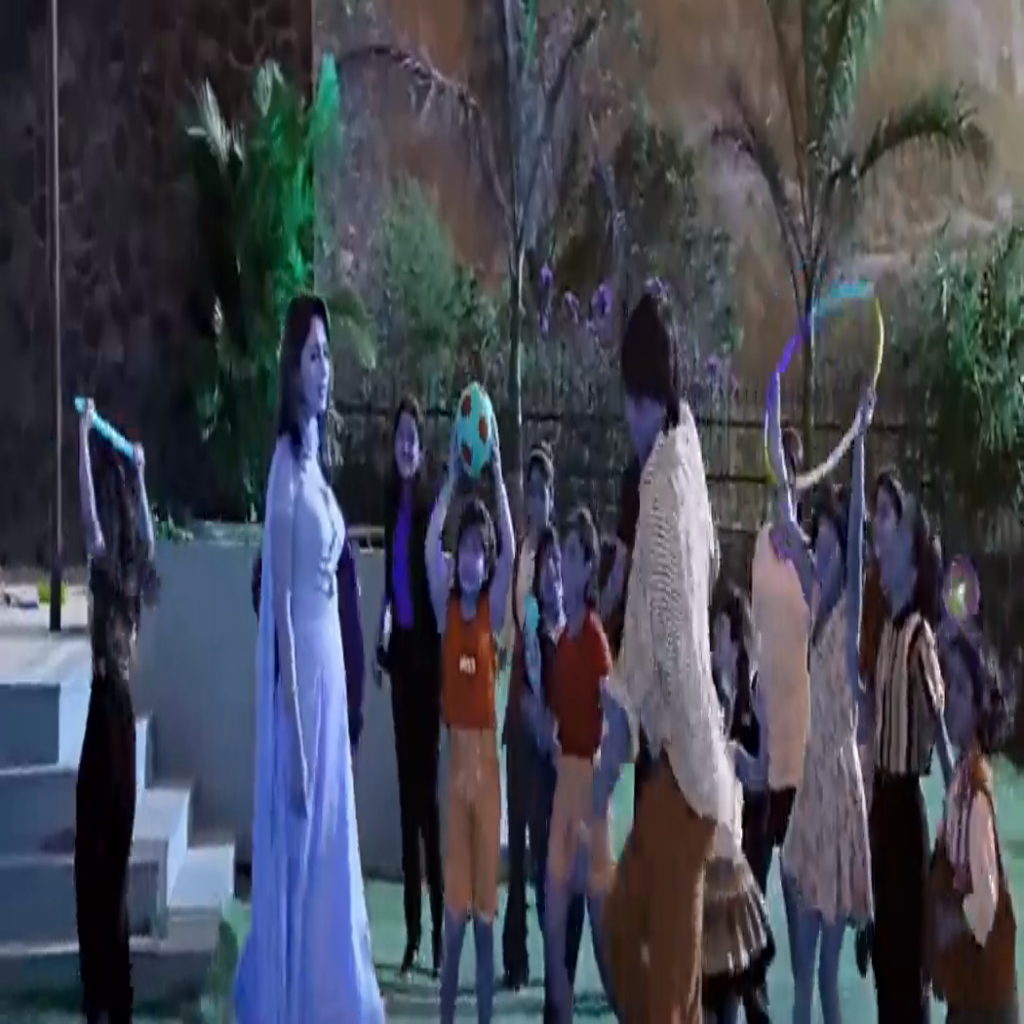

In [130]:
IMAGE_SIZE = 1024
x_image_string = tf.io.read_file(x_files[0])
x_image_decoded = tf.image.decode_png(x_image_string, channels=3)
img = tf.image.resize(x_image_decoded, [IMAGE_SIZE, IMAGE_SIZE])



import cv2
from google.colab.patches import cv2_imshow
cv2_imshow(img.numpy())

In [117]:
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
train_ds, test_ds = get_datasets()
test_ds = jax_utils.replicate(test_ds)
rng = jax.random.PRNGKey(0)

rng, init_rng = jax.random.split(rng)

HxW, Channels = next(batches)[0].shape
state = create_train_state(jax.random.split(init_rng, jax.device_count()),(HxW, Channels),learning_rate)

for epoch in range(1, num_epochs + 1):
  rng, input_rng = jax.random.split(rng)
  state, train_loss = train_epoch(state, train_ds, batch_size, input_rng)

  # _, test_loss = jax_utils.unreplicate(apply_model(state, test_ds['image'], test_ds['label']))

  logging.info('epoch:% 3d, train_loss: %.4f ' % (epoch, train_loss))

NameError: ignored

In [ ]:
# same as before, but using @pad_shard_unshard decorator

# manually padding
# => precise & allows for data parallelism

@jax.pmap
def get_preds(variables, inputs):
  print('retrigger compilation', inputs.shape)
  return model.apply(variables, inputs)

ds = tfds.load(dataset_name, split=tfds.split_for_jax_process('test'))
per_host_batch_size = per_device_batch_size * jax.local_device_count()
ds = ds.batch(per_host_batch_size, drop_remainder=False)

correct = total = 0
for batch in ds.as_numpy_iterator():
  preds = flax.jax_utils.pad_shard_unpad(get_preds)(
      vs, batch['image'], min_device_batch=per_device_batch_size)
  total += len(batch['image'])
  correct += (batch['label'] == preds.argmax(axis=-1)).sum()

correct = correct.item()
correct, total, correct / total